In [3]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

import tqdm
import pandas as pd
import numpy as np
import json

2021-12-15 16:01:40.590268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pani/anaconda3/envs/mlo-project-1/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-15 16:01:40.590313: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import batch_normalization
from keras.models import Model

In [5]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

2021-12-15 16:01:42.157019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-15 16:01:42.157114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pani/anaconda3/envs/mlo-project-1/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-15 16:01:42.157147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pani/anaconda3/envs/mlo-project-1/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-15 16:01:42.157174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynami

In [7]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [8]:
def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model

In [9]:
droplets_head = layer_adder(vgg16_model, 3)

droplets_model = Model(inputs = vgg16_model.input, outputs = droplets_head)

In [10]:
from keras.optimizers import adam_v2

In [11]:
droplets_model.compile(loss = "categorical_crossentropy",
                       optimizer = "Adam",
                       metrics = ["accuracy", "precision", "recall"])

In [12]:
import json 

with open("datasets/droplets/label-data-min.json") as infile:
    label_json = json.load(infile)

In [13]:
images = []
labels = []
for image in label_json:
    
    image_filename = image["image"][24:]
    # print(image_filename)
    img = cv2.imread(f"datasets/droplets/label-data/{image_filename}")
    
    if img is None:
        print(image_filename)
    img = cv2.resize(img, (224,224))
    
    img = np.array(img, dtype=np.float32)

    # Normalise the images
    img /= 255
    
    label = image["choice"]
    
    if label == "Not_Droplet":
        label = 2
    if label == "Empty":
        label = 0
    if label == "Bacteria":
        label = 1

    
    images.append(img)
    
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [14]:
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [15]:
labels = one_hot(labels, 3)

In [16]:
tf.config.run_functions_eagerly(True)

In [17]:
print(images.shape)
print(labels.shape)

(2400, 224, 224, 3)
(2400, 3)


In [18]:
history = droplets_model.fit(x = images, y = labels, validation_split=0.3, epochs=4)

Epoch 1/4


/home/pani/anaconda3/envs/mlo-project-1/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/53 [=====>........................] - ETA: 6:51 - loss: 0.7529 - accuracy: 0.7161

In [129]:
from src.circle_detection.hough_circle_detection import hough_circle_detection
import math

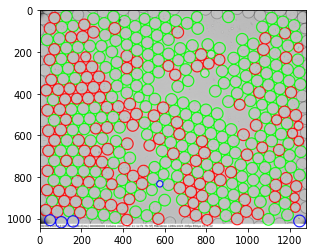

In [175]:
test_img_path = "datasets/droplets/test/original/2_hrs_lambda_10_c0000000000.jpg"

test_img = cv2.imread(test_img_path)
output_test_img = test_img.copy()

test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

circles_test_img = hough_circle_detection(test_img)

if circles_test_img is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circlesRound_test_img = np.round(circles_test_img[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    
    height, width = test_img.shape[:2]
    
    for (x, y, r) in circlesRound_test_img:
        if (x - r < 0 or x + r > width or y - r < 0 or y + r > height):
            continue
        
        
        x_min = math.floor(max(x - r, 0))
        x_max = math.ceil(min(x + r, width))
        y_min = math.floor(max(y - r, 0))
        y_max = math.ceil(min(y + r, height))

        droplet = test_img[y_min:y_max, x_min:x_max]

        #plt.imshow(output_test_img)
        
        mask = np.zeros_like(droplet)
        mask = cv2.circle(mask, (round(r), round(r)), round(r), (255,255,255), -1)
        masked_droplet = cv2.bitwise_and(droplet, mask)
        
        masked_droplet = cv2.resize(masked_droplet, (224,224))
    
        masked_droplet = np.array(masked_droplet, dtype=np.float32)

        # Normalise the images
        masked_droplet /= 255
        
        masked_droplet_3 = np.zeros((1, 224, 224, 3))
        masked_droplet_3[0, :, :, 0] = masked_droplet
        masked_droplet_3[0, :, :, 1] = masked_droplet
        masked_droplet_3[0, :, :, 2] = masked_droplet
        
        
        #plt.imshow(masked_droplet)
    
        #cv2.circle(output_test_img, (x, y), r, (0, 255, 0), 4)
        prediction = droplets_model.predict(masked_droplet_3)
        
        best_i = np.argmax(prediction)
        
        cv2.circle(output_test_img, (x, y), r, (255 * int(best_i == 0), 255 * int(best_i == 1), 255 * int(best_i == 2)), 4)
        
    plt.imshow(output_test_img)
else:
    print ('No circles found')

plt.imsave("output.png", output_test_img)